## Библиотеки

In [152]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
from copy import deepcopy

In [153]:
warnings.filterwarnings('ignore')
np.random.seed(1)
sns.set_style('darkgrid')
%matplotlib inline

## Данные

In [154]:
# Параметры для датасета.
N = 5000
factor = 0.1
noise = 0.1

In [155]:
n_iteration = 50000
learning_rate = 0.0001
momentum_factor = .5

In [156]:
# Сгенерируем данные.
X, y = make_circles(n_samples=N,
                    shuffle=True,
                    factor=factor, 
                    noise=noise)

In [157]:
# Определим матрицу результатов.
Y = np.zeros((N, 2))
for c in [0, 1]:
    Y[y == c, c] = 1

In [158]:
f'Форма : X: {X.shape} | Y: {Y.shape} | y: {y.shape}'

'Форма : X: (5000, 2) | Y: (5000, 2) | y: (5000,)'

Визуализируем данные

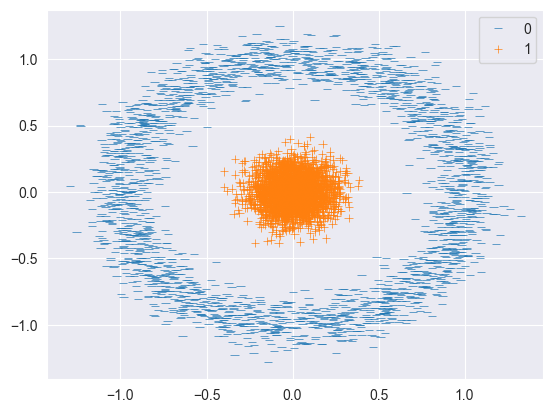

In [159]:
sns.scatterplot(x=X[:, 0],
                y=X[:, 1],
                hue=y,
                style=y,
                markers=['_', '+']);

## Архитектура нейронной сети

In [160]:
def logistic(x):
    '''Логистическая функция.'''
    return 1 / (1 + np.exp(-x))

In [161]:
def hidden_layer(input_data, weights, bias):
    '''Вычисление скрытого слоя.'''
    return logistic(input_data@weights + bias)

In [162]:
def softmax(x):
    '''Softmax функция.'''
    return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims=True)

In [163]:
def output_layer(hidden_activations, weights, bias):
    '''Вычисление выходного слоя.'''
    return softmax(hidden_activations@weights + bias)

## Прямое распространение

In [164]:
def forward_prop(data, hidden_weights, hidden_bias, output_weights, output_bias):
    '''Нейронная сеть, как функция.'''
    hidden_activations = hidden_layer(data, hidden_weights, hidden_bias)
    return output_layer(hidden_activations, output_weights, output_bias)

In [165]:
def predict(data, hidden_weights, hidden_bias, output_weights, output_bias):
    '''Предсказывает класс 0 или 1.'''
    y_pred_proba = forward_prop(data, 
                                hidden_weights,
                                hidden_bias,
                                output_weights,
                                output_bias)
    return np.around(y_pred_proba)

In [166]:
def loss(y_hat, y_true):
    '''Кросс-энтропия.'''
    return -(y_true * np.log(y_hat)).sum()

## Обратное распространение

In [167]:
def loss_gradient(y_hat, y_true):
    '''Градиент выходного слоя.'''
    return y_hat - y_true

In [168]:
def output_weight_gradient(H, loss_grad):
    '''Градиенты для весов выходного слоя.'''
    return H.T@loss_grad

In [169]:
def output_bias_gradient(loss_grad):
    '''Градиенты для смещения выходного слоя.'''
    return np.sum(loss_grad, axis=0, keepdims=True)

In [170]:
def hidden_layer_gradient(H, out_weights, loss_grad):
    '''Ошибка на скрытом слое.'''
    return H * (1 - H) * (loss_grad@out_weights.T)

In [171]:
def hidden_weight_gradient(X, hidden_layer_grad):
    '''Градиент весовых параметров на скрытом слое.'''
    return X.T@hidden_layer_grad

In [172]:
def hidden_bias_gradient(hidden_layer_grad):
    '''Градиент параметров смещения на выходном слое.'''
    return np.sum(hidden_layer_grad, axis=0, keepdims=True)

In [173]:
def initialize_weights():
    '''Иницианализация весов для скрытых, выходных и смещения.'''

    # Initialize hidden layer parameters
    hidden_weights = np.random.randn(2, 3)
    hidden_bias = np.random.randn(1, 3)

    # Initialize output layer parameters
    output_weights = np.random.randn(3, 2)
    output_bias = np.random.randn(1, 2)
    return hidden_weights, hidden_bias, output_weights, output_bias

In [174]:
def compute_gradients(X, y_true, w_h, b_h, w_o, b_o):
    '''Оценка градиентов для обновления параметров.'''

    hidden_activations = hidden_layer(X, w_h, b_h)
    y_hat = output_layer(hidden_activations, w_o, b_o)

    loss_grad = loss_gradient(y_hat, y_true)
    out_weight_grad = output_weight_gradient(hidden_activations, loss_grad)
    out_bias_grad = output_bias_gradient(loss_grad)

    hidden_layer_grad = hidden_layer_gradient(hidden_activations, w_o, loss_grad)
    hidden_weight_grad = hidden_weight_gradient(X, hidden_layer_grad)
    hidden_bias_grad = hidden_bias_gradient(hidden_layer_grad)

    return [hidden_weight_grad, hidden_bias_grad, out_weight_grad, out_bias_grad]

### Проверка градиентов

In [175]:
eps = 1e-4

params = initialize_weights()

grad_params = compute_gradients(X, Y, *params)

for i, param in enumerate(params):
    rows, cols = param.shape
    for row in range(rows):
        for col in range(cols):
            params_low = deepcopy(params)
            params_low[i][row, col] -= eps

            params_high = deepcopy(params)
            params_high[i][row, col] += eps
            
            loss_high = loss(forward_prop(X, *params_high), Y)
            loss_low = loss(forward_prop(X, *params_low), Y)
            numerical_gradient = (loss_high - loss_low) / (2 * eps)

            backprop_gradient = grad_params[i][row, col]
            
            assert np.allclose(numerical_gradient, backprop_gradient), ValueError(
                    f'Numerical gradient of {numerical_gradient:.6f} not close to '
                    f'backprop gradient of {backprop_gradient:.6f}!')

print('No gradient errors found')

No gradient errors found


## Тренировка сети

In [176]:
def update_momentum(X, y_true, param_list,
                    Ms, momentum_term,
                    learning_rate):
    '''Обновить матрицу импульса.'''
    # param_list = [hidden_weight, hidden_bias, out_weight, out_bias]
    # gradients = [hidden_weight_grad, hidden_bias_grad,
    #               out_weight_grad, out_bias_grad]
    gradients = compute_gradients(X, y_true, *param_list)
    return [momentum_term * momentum - learning_rate * grads
            for momentum, grads in zip(Ms, gradients)]

In [177]:
def update_params(param_list, Ms):
    '''Обновить параметры.'''
    # param_list = [Wh, bh, Wo, bo]
    # Ms = [MWh, Mbh, MWo, Mbo]
    return [P + M for P, M in zip(param_list, Ms)]

In [178]:
def train_network(iterations=1000, lr=.01, mf=.1):
    '''Иницианализация весов и смещений.'''
    param_list = list(initialize_weights())

    Ms = [np.zeros_like(M) for M in param_list]

    train_loss = [loss(forward_prop(X, *param_list), Y)]
    for i in range(iterations):
        if i % 1000 == 0: print(f'{i:,d}', end=' ', flush=True)
        Ms = update_momentum(X, Y, param_list, Ms, mf, lr)

        param_list = update_params(param_list, Ms)
        train_loss.append(loss(forward_prop(X, *param_list), Y))

    return param_list, train_loss

In [179]:
# n_iterations = 20000
# results = {}
# for learning_rate in [.01, .02, .05, .1, .25]:
#     for momentum_factor in [0, .01, .05, .1, .5]:
#         print(learning_rate, momentum_factor)
#         trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)
#         results[(learning_rate, momentum_factor)] = train_loss[::1000]

In [180]:
%%time
trained_params, train_loss = train_network(iterations=n_iterations, lr=learning_rate, mf=momentum_factor)

0 1,000 2,000 3,000 4,000 5,000 6,000 7,000 8,000 9,000 10,000 11,000 12,000 13,000 14,000 15,000 16,000 17,000 18,000 19,000 CPU times: total: 5.52 s
Wall time: 17.3 s


In [181]:
hidden_weights, hidden_bias, output_weights, output_bias = trained_params

## Визуализация ошибки обучения

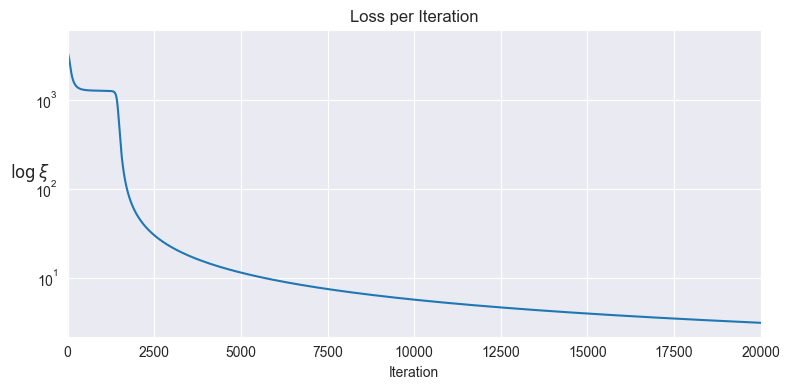

In [182]:
ax = pd.Series(train_loss).plot(figsize=(8, 4), title='Loss per Iteration', xlim=(0, n_iterations), logy=True)
ax.set_xlabel('Iteration')
ax.set_ylabel('$\\log \\xi$', fontsize=12, rotation=0)
plt.tight_layout()

## Граница решения

In [183]:
n_vals = 200
x1 = np.linspace(-1.5, 1.5, num=n_vals)
x2 = np.linspace(-1.5, 1.5, num=n_vals)
xx, yy = np.meshgrid(x1, x2)  

feature_space = np.zeros((n_vals, n_vals))
for i in range(n_vals):
    for j in range(n_vals):
        X_ = np.asarray([xx[i, j], yy[i, j]])
        feature_space[i, j] = np.argmax(predict(X_, *trained_params))

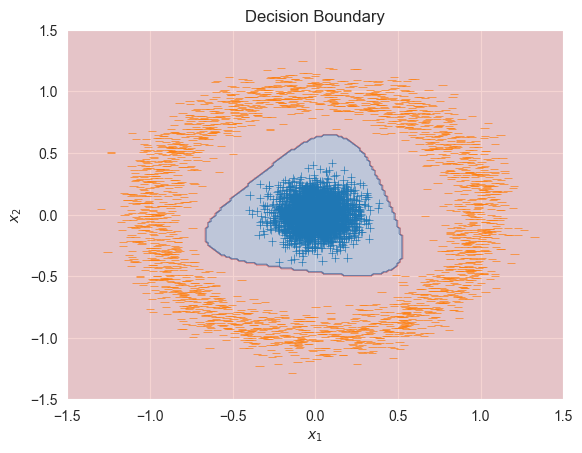

In [184]:
cmap = ListedColormap([sns.xkcd_rgb["pale red"],
                       sns.xkcd_rgb["denim blue"]])

plt.contourf(xx, yy, feature_space, cmap=cmap, alpha=.25)

data = pd.DataFrame(X, columns=['$x_1$', '$x_2$']).assign(Class=pd.Series(y).map({0:'negative', 1:'positive'}))
sns.scatterplot(x='$x_1$', y='$x_2$', hue='Class', data=data, style=y, markers=['_', '+'], legend=False)
plt.title('Decision Boundary')
plt.savefig('boundary', dpi=300);